# Logistic Regression with Python
We'll be trying to predict a classification- survival or deceased.

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv('titanic.csv', delimiter = '\t')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [4]:
train.shape

(156, 12)

In [5]:
train.isnull().sum()  # cabin more than 40% data is missing so , we drop this column

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             30
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          125
Embarked         1
dtype: int64

<AxesSubplot:>

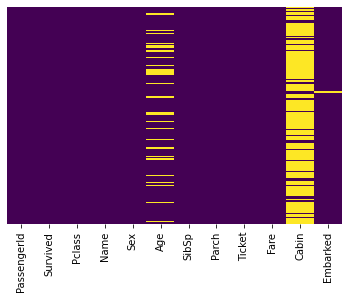

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

<AxesSubplot:xlabel='Survived', ylabel='count'>

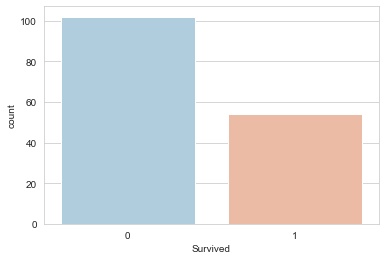

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

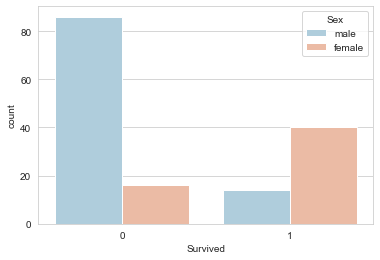

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

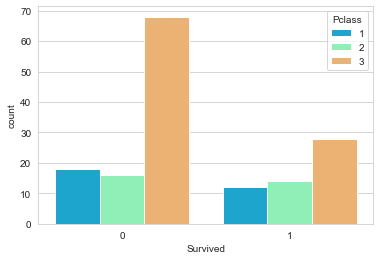

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<AxesSubplot:>

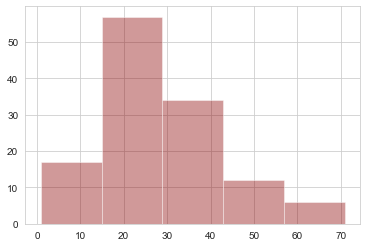

In [10]:
train['Age'].hist(bins=5,color='darkred',alpha=0.4)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

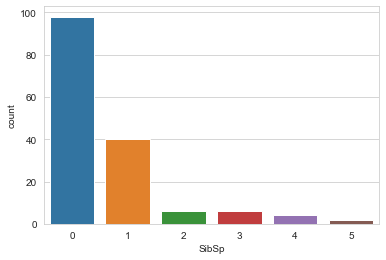

In [11]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

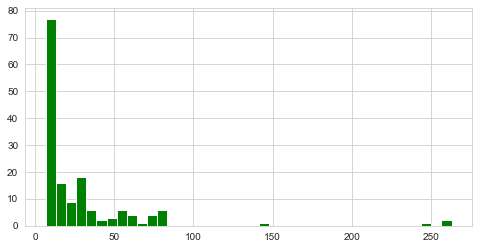

In [12]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<AxesSubplot:xlabel='Age'>

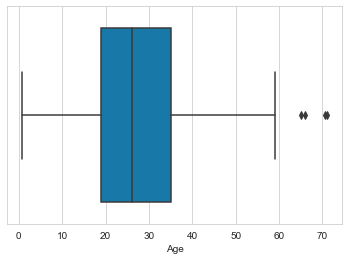

In [13]:
sns.boxplot(x='Age',data=train,palette='winter')

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

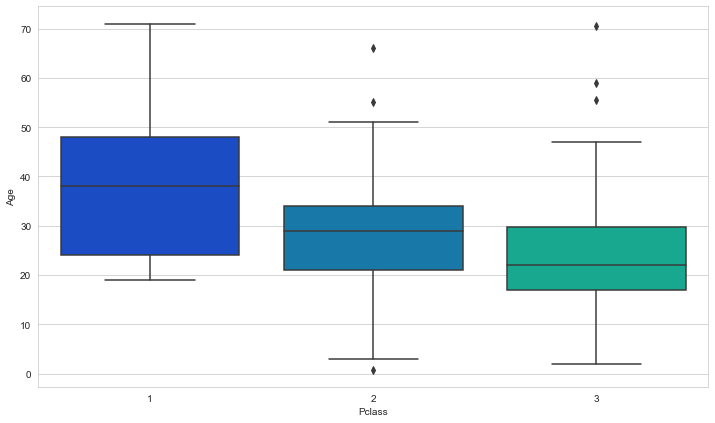

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [15]:
# Outlier Treatment
c1 = (train['Pclass']==3)&(train['Age']>42)
c2 = (train['Pclass']==2)&(train['Age']>50)
c3 = (train['Pclass']==2)&(train['Age']<8)

train['new age']=np.select([c1,c2,c3],[23,27,27], train['Age'])

<AxesSubplot:xlabel='Pclass', ylabel='new age'>

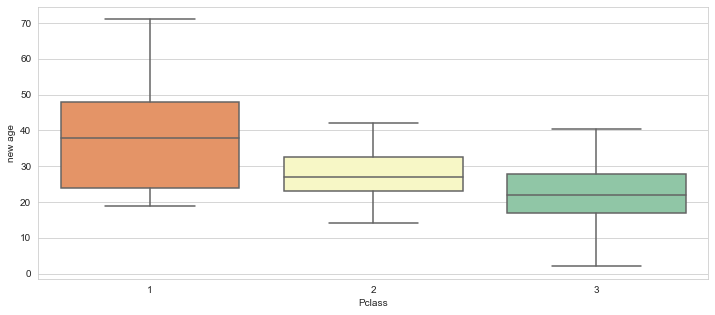

In [16]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Pclass',y='new age',data=train,palette='Spectral')

In [36]:
# Treat NAN values for AGE
print(train['new age'].isna().sum()) # 30 nan
train['new age'].fillna(train.Age.median(), inplace = True)
train['new age'].isna().sum() # 0 nan

30


0

In [18]:
# Treat NAN values for EMBARKD
train.Embarked.isna().sum() # 1 nan 
train.Embarked.mode()[0] # finding the most common occuring value from the column
train.Embarked.fillna(train.Embarked.mode()[0], inplace = True)
train.Embarked.isna().sum() # 0 nan

0

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [37]:
# treating Age NAN Values basied on PClass
def impute_age(cols):
    Age2 = cols[0]
    Pclass2 = cols[1]
    
    if pd.isna(Age2):

        if Pclass2 == 1:
            return train[train['Pclass']==1]['new age'].median()

        elif Pclass2 == 2:
            return train[train['Pclass']==2]['new age'].median()

        else:
            return train[train['Pclass']==3]['new age'].median()

    else:
        return Age2

In [38]:
train['new age'] = train[['new age','Pclass']].apply(impute_age,axis=1)

In [39]:
train['new age'].nunique()

48

<AxesSubplot:>

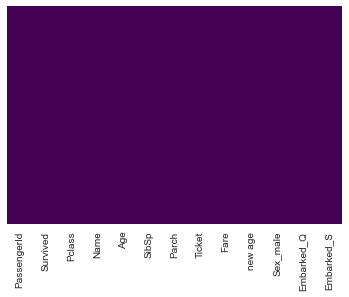

In [40]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [23]:
train.drop('Cabin',axis=1,inplace=True)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,new age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,35.0


In [25]:
#train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  156 non-null    int64  
 1   Survived     156 non-null    int64  
 2   Pclass       156 non-null    int64  
 3   Name         156 non-null    object 
 4   Sex          156 non-null    object 
 5   Age          156 non-null    float64
 6   SibSp        156 non-null    int64  
 7   Parch        156 non-null    int64  
 8   Ticket       156 non-null    object 
 9   Fare         156 non-null    float64
 10  Embarked     156 non-null    object 
 11  new age      126 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 14.8+ KB


In [27]:
train = pd.get_dummies(train, columns = ['Sex', 'Embarked'],drop_first=True)

In [28]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,new age,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,22.0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,38.0,0,0,0


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  156 non-null    int64  
 1   Survived     156 non-null    int64  
 2   Pclass       156 non-null    int64  
 3   Name         156 non-null    object 
 4   Age          156 non-null    float64
 5   SibSp        156 non-null    int64  
 6   Parch        156 non-null    int64  
 7   Ticket       156 non-null    object 
 8   Fare         156 non-null    float64
 9   new age      156 non-null    float64
 10  Sex_male     156 non-null    uint8  
 11  Embarked_Q   156 non-null    uint8  
 12  Embarked_S   156 non-null    uint8  
dtypes: float64(3), int64(5), object(2), uint8(3)
memory usage: 12.8+ KB


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived','Age','Name','Ticket','PassengerId'],axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
logmodel2 = LogisticRegression()
logmodel2.fit(X_train,y_train)

C:\Users\z011934\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [46]:
X_test.head()

,Pclass,SibSp,Parch,Fare,new age,Sex_male,Embarked_Q,Embarked_S
80,3,0,0,9.000,22.0,1,0,1
106,3,0,0,7.650,21.0,0,0,1
116,3,0,0,7.750,23.0,1,1,0
129,3,0,0,6.975,23.0,1,0,1
32,3,0,0,7.750,26.0,0,1,0


In [48]:
predictions = logmodel2.predict(X_test)
predictions

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1], dtype=int64)

In [49]:
y_test.head()

80     0
106    1
116    0
129    0
32     1
Name: Survived, dtype: int64

In [50]:
predictions[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [51]:
logmodel2.predict(np.array([[1,0,2,30,0,0,0,70], [1,0,2,30,1,0,0,70]]))

array([0, 0], dtype=int64)

In [52]:
logmodel2.predict(X_test.iloc[0:2].values)

array([0, 1], dtype=int64)

## Evaluation

We can check precision,recall,f1-score using classification report!

In [53]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,classification_report

In [54]:
precision_score(y_test,predictions)  # 3

0.8

In [55]:
recall_score(y_test,predictions)  # 2

0.5217391304347826

In [56]:
accuracy_score(y_test,predictions)  # 4

0.7021276595744681

In [57]:
f1_score(y_test,predictions)   # 1

0.6315789473684211

In [58]:
confusion_matrix(y_test,predictions)


# specificity =  TN/(FP+TN)

array([[21,  3],
       [11, 12]], dtype=int64)

In [60]:
%%time
import pickle
# # saved the trained model in file with given name
pickle_out = open("titanic_pred.pickle","wb") # name of my pickle file , wb -write
pickle.dump(logmodel2, pickle_out)
pickle_out.close()

Wall time: 942 µs


In [61]:
# loading the pickeled model
pickle_in = open("titanic_pred.pickle","rb") # rb -> read the pickel file
trained_model = pickle.load(pickle_in)
trained_model.predict(X_test)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1], dtype=int64)

In [62]:
trained_model.predict(np.array([[3,0,0,7,21,1,0,1]]))

array([0], dtype=int64)

In [63]:
X_test.head(1)

,Pclass,SibSp,Parch,Fare,new age,Sex_male,Embarked_Q,Embarked_S
80,3,0,0,9.0,22.0,1,0,1


In [65]:
trained_model.predict(np.array([[1,55,0,1,150,55,1,0]]))

array([0], dtype=int64)